### Author: Ganesh


## Notes:

In the rest of the notebook, the term `data matrix` refers to a two dimensional numpy array where instances are encoded as rows, e.g. a data matrix with 100 rows and 4 columns is to be interpreted as a collection of 100 instances each with four features.  

---

When a required function can be implemented directly by a library function it is intended that the candidate should write her own implementation of the function, e.g. a function to compute the accuracy, the confusion table, etc.

---

You are asked to solve the quadratic optimization problem using the library [cvxopt](http://cvxopt.org/).  

You can install the library via:

`pip install cvxopt`

or

`conda install -c conda-forge cvxopt`

Then you should be able to import the module with:

    `import cvxopt`
    
---

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import cvxopt

# the following is used in unit testing, please ignore 
import sys
sys.path.insert(0,'../../../')

## Question 1


a) Make the following functions: 

- `TPR = true_positive_rate(preds, targets)` 
- `FPR = false_positive_rate(preds, targets)` 

to compute the sequence of true (resp. false) positive rates for all possible threshold values.
The functions should work equally well when the input is of the type `list` or `numpy array`. 
The input `preds` contains the predictions as float numbers and the input `targets` contains the true class labels encoded as the integers `1` or `-1`. 

b) Make the function `compute_auc(TPR, FPR)` to compute the area under the curve of the ROC given in input the list of true poritive rates and false positive rates for all possible threshold values.

In [2]:
def true_positive_rate(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    ids = np.argsort(-preds)
    sorted_targets = targets[ids]
    y = sorted_targets == 1
    return np.cumsum(y.astype(int))/np.sum(y)

In [3]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [4]:
def false_positive_rate(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    ids = np.argsort(-preds)
    sorted_targets = targets[ids]
    n = sorted_targets != 1
    return np.cumsum(n.astype(int))/np.sum(n)

In [5]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [6]:
def compute_auc(TPR, FPR):
    areas = [(FPR[i+1] - FPR[i])*TPR[i] for i in range(len(TPR)-1)]
    auc = np.sum(areas)
    return auc

In [7]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 2


a) Make a function `classifier = train_rf(X_train, y_train, param)` that takes in input a data matrix `X_train`, an associated target array `y_train`, and a single scalar parameter `param` which corresponds to the maximum depth of the decision trees used in the forest, and returns a fit classifier object of type `sklearn.ensemble.RandomForestClassifier`. In this implementation you must fix the number of decision trees used in the forest to the value 10.

b) Make a function `preds = test_rf(X_test, classifier)` that takes in input a data matrix `X_test`, a classifier object `classifier` and returns the prediction array `preds`.

c) Make a function `scores = score_rf(X_test, classifier)` that takes in input a data matrix `X_test`, a classifier object `classifier` and returns the array `scores` containing the probability for each instance to belong to the positive class (which is assumed to be encoded with the integer `1`).

In [8]:
from sklearn.ensemble import RandomForestClassifier

def train_rf(X_train, y_train, param):
    return RandomForestClassifier(n_estimators=10,max_depth=param).fit(X_train,y_train)

In [9]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [10]:
def test_rf(X_test, estimator):
    return estimator.predict(X_test)

In [11]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [12]:
def score_rf(X_test, estimator):
    return estimator.predict_proba(X_test)[:,1]

In [13]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 3

Make a function `scores_list = compute_scores(train_func, score_func, param, X_train, y_train, X_test, num)` that trains a classifier on `X_train, y_train` and tests it on `X_test` a number of times equal to `num`. The function outputs a list of score arrays of size `num`, and each score array contains the predicted probability for each instance in `X_test` to belong to the positive class (which is assumed to be encoded with the integer `1`). Note that by using a randomized classifier (like the random forest) you will get different output score arrays each time. 

In [14]:
def compute_scores(train_func, score_func, param, X_train, y_train, X_test, num):
    scores = []
    for _ in range(num):
        classifier = train_func(X_train,y_train,param)
        scores.append(score_func(X_test,classifier))
    return scores

In [15]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 4

Make a function `tpr_low, tpr_high, tpr_mid, fpr = compute_tpr_fpr_range(scores_list, y_test, false_positive_rate_func, true_positive_rate_func, low_quantile, high_quantile)`. The function takes in input a list of predicted scores, the true classes, a function to compute the false positive rate and one to compute the true positive rate and two threshold values: low_quantile and high_quantile. The function will output 4 lists (or arrays): 

- tpr_low: the true positive rate corresponding to the `low_quantile` true positive rate 
- tpr_high: the true positive rate corresponding to the `high_quantile` true positive rate
- tpr_mid: the true positive rate corresponding to the median true positive rate
- fpr: the false positive rate

Note: instead of a single pair `(true positive rate,false positive rate)` the `scores_list` allows you to have mutiple true positive rate values for the same false positive rate value, i.e. a distribution of true positive rate values; the function `compute_tpr_fpr_range` must output the values corresponding to the quantiles of such distributions (e.g. the true positive rate corresponding to the 95 percentile of the true positive rate distribution) for each corresponding false positive rate value (see the figure the Checkpoint cell below).


In [16]:
def compute_tpr_fpr_range(scores_list, y_test, false_positive_rate_func, true_positive_rate_func, low_quantile, high_quantile):
    tpr = []
    fpr = []
    for i in range(len(scores_list)):
        tpr = np.append(tpr, true_positive_rate_func(scores_list[i],y_test))
        fpr = np.append(fpr, false_positive_rate_func(scores_list[i],y_test))
    idx = np.argsort(fpr)
    fpr = fpr[idx]
    tpr = tpr[idx]
    fpr, indexes = np.unique(fpr,return_index=True)
    indexes = np.append(indexes, len(idx))
    tpr_high = []
    tpr_low = []
    tpr_mid = []
    for i in range(len(indexes)-1):
        tprs = tpr[indexes[i]:indexes[i+1]]
        tpr_mid.append(np.median(tprs))
        #tpr_mid.append(np.quantile(tprs,q = (high_quantile+low_quantile)/2,interpolation='midpoint'))
        tpr_high.append(np.quantile(tprs,q = high_quantile,interpolation='higher'))
        tpr_low.append(np.quantile(tprs,q = low_quantile,interpolation='lower'))
    return tpr_low,tpr_high,tpr_mid,fpr

In [17]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [18]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 5

Make a function `plot_roc(tpr_low, tpr_high, tpr_mid, fpr, compute_auc_func)` that takes in input the true positive rate corresponding to the `low_quantile` true positive rate, the true positive rate corresponding to the `high_quantile` true positive rate, the true positive rate corresponding to the median true positive rate, the false positive rate and a function to compute the ROC AUC and produces a plot like:

<img src='plot1.png' width=300>

In [19]:
def plot_roc(tpr_low, tpr_high, tpr_mid, fpr, compute_auc_func):
    plt.figure(figsize=(6,6))
    plt.fill_between(fpr,tpr_low,tpr_high,color='gray',alpha=0.4)
    plt.plot(fpr,tpr_mid,c='black')
    plt.scatter(fpr,tpr_mid,c='black')
    plt.plot([0,1],[0,1],'--', c='gray', alpha=.4)
    plt.grid()
    plt.title('AUC ROC:%.2f'%compute_auc_func(tpr_mid, fpr))
    plt.show()

In [20]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Checkpoint

This is just a check-point, i.e. it is for you to see that you are correctly implementing all functions. 

Execute the following code (just execute the next cell):
```python
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=500, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.1, class_sep=1.0, random_state=2)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=50, random_state=2)

scores_list = compute_scores(train_rf, score_rf, 5, X_train, y_train, X_test, num=100)
tpr_low, tpr_high, tpr_mid, fpr = compute_tpr_fpr_range(scores_list, y_test, false_positive_rate, true_positive_rate, low_quantile=0.05, high_quantile=0.95)
plot_roc(tpr_low, tpr_high, tpr_mid, fpr, compute_auc)
```

You should obtain something like:

<img src='plot1.png' width=300>

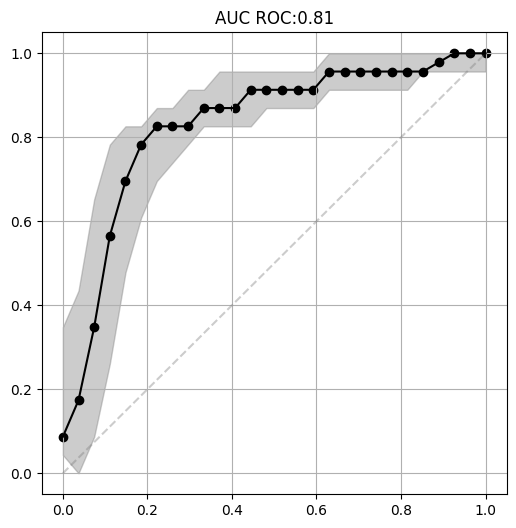

In [21]:
# Just run the following code, do not modify it

from sklearn.datasets import make_classification
X,y = make_classification(n_samples=500, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.1, class_sep=1.0, random_state=2)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=50, random_state=2)

scores_list = compute_scores(train_rf, score_rf, 5, X_train, y_train, X_test, num=100)
tpr_low, tpr_high, tpr_mid, fpr = compute_tpr_fpr_range(scores_list, y_test, false_positive_rate, true_positive_rate, low_quantile=0.05, high_quantile=0.95)
plot_roc(tpr_low, tpr_high, tpr_mid, fpr, compute_auc)

## Question 6

Solve a constrained quadratic program (QP) with `cvxopt`. 

The standard form for a QP in `cvxopt` notation is:

\begin{align*}
        \min_{x}  \tfrac{1}{2} x^T P x &+ q^T x \\
        \text{such that   }\quad  Gx &\preceq h\\
        Ax & = b
\end{align*}
where $Gx \preceq h$ means that the inequality is taken element-wise for each row of $Gx$ and $h$.

In `cvxopt` the QP is defined by the parameters $P, q, G, h, A$ and $b$.  The matrix $P$ and the vector $q$ must be specified, but the others are optional.   Note that all optimisations must be manipulated to be of this form.

Consider this problem:

\begin{align*}
        \min_{x}  \tfrac{1}{8} x^2 - \frac{1}{10} y ^ 2+ & \frac{1}{4} x + y\\
        \text{such that   }\quad y - x & \le 0\\
        x + 3y & \ge 15\\
        3x + 5y & \ge 40\\
        \frac{1}{2} x + 4y & \le 50
\end{align*}

Consider a grid covering the range $[0, 15] \times [-2, 15]$ (i.e. $x \in [0, 15]$ and $y \in [-2, 15]$).

Make a function `P,q,G,h = make_matrices()` that returns the corresponding matrices of type `cvxopt.matrix` for this specific problem.

In [22]:
from cvxopt import matrix

def make_matrices():
    P = matrix(np.array([[1/8,0],[0, -1/10]]), tc='d')
    q = matrix(np.array([1/4,1]).reshape(-1,1), tc='d')
    G = matrix(np.array([[-1,1],[-1,-3],[-3,-5],[1/2,4]]), tc='d')
    h = matrix(np.array([0,-15,-40,50]).reshape(-1,1), tc='d')
    return P, q, G, h

In [23]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 7

Make a function `sol, obj = compute_solution_and_objective(P,q,G,h)` that takes in input the corresponding matrices of type `cvxopt.matrix` and returns `sol` containing the vector (as a numpy array) that minimizes the constrained QP problem and a scalar `obj` that contains the value of the objective function evaluated at the solution (i.e. the minimum of the objective function).

In [24]:
from cvxopt import solvers

def compute_solution_and_objective(P,q,G,h):
    sol = solvers.qp(P, q, G, h)
    return sol['x'], sol['primal objective']

In [25]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 8

Make a function `plot_solution(sol)` that takes in input the solution array `sol` to the previous QP problem and displays:

- the feasibility region by representing the constraints 
- the objective function via colored contour lines and an associated color scale 
- the solution as a red dot

The result (applied to a different QP problem) should resemble in style the following plot:

<img src='plot2b.png' width=300>

In [26]:
def q_func(x, y):
    """Evaluate the objective function"""
    return ((x * x)/8) - ((y * y)/10) + (x/4) + y

def plot_solution(sol):
    x = np.linspace(0, 15, 50)
    y = np.linspace(-2, 15, 50)
    X, Y = np.meshgrid(x, y)
    F0 = q_func(X, Y)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title(r'$f_0(x, y)$')
    plt.axhline(0.0)
    plt.axvline(0.0)
    plt.contour(X, Y, F0, 50)
    plt.plot(x, x, 'r')
    plt.plot(x, (15 - x)/ 3, 'r')
    plt.plot(x, (40 - (3 * x)) / 5, 'b')
    plt.plot(x, (50 -  (x/2)) / 4, 'g')
    plt.scatter(sol[0],sol[1],s=200,marker='o',c='r')
    plt.colorbar()
    plt.axis('scaled')
    plt.show()

In [27]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Checkpoint

This is just a check-point, i.e. it is for you to see that you are correctly implementing all functions.

Execute the following code (just execute the next cell):
```python
P,q,G,h = make_matrices()
sol, obj = compute_solution_and_objective(P,q,G,h)
plot_solution(sol)
print(sol, obj)
```

If you had to solve the following **different** problem:
\begin{align*}
        \min_{x}  \tfrac{1}{2} x^2 + & 3x + 4y\\
        \text{such that   }\quad x, y & \ge 0\\
        x + 3y & \ge 15\\
        2x + 5y & \le 100\\
        3x + 4y & \le 80
\end{align*}
in the domain $[-5, 20] \times [-5, 20]$, then you would obtain a picture like this:

<img src='plot2.png' width=300>

Note however that **your problem is different** and you will obtain a different figure and a different solution.

     pcost       dcost       gap    pres   dres
 0:  4.7441e+00  1.9683e+02  3e+02  4e-01  8e+01
 1:  9.4055e+00 -4.9666e+00  2e+01  9e-03  2e+00
 2:  7.4712e+00  5.1873e+00  2e+00  4e-04  8e-02
 3:  6.6343e+00  6.2273e+00  4e-01  6e-05  1e-02
 4:  6.5647e+00  6.5588e+00  6e-03  6e-07  1e-04
 5:  6.5625e+00  6.5625e+00  6e-05  6e-09  1e-06
 6:  6.5625e+00  6.5625e+00  6e-07  6e-11  1e-08
Optimal solution found.


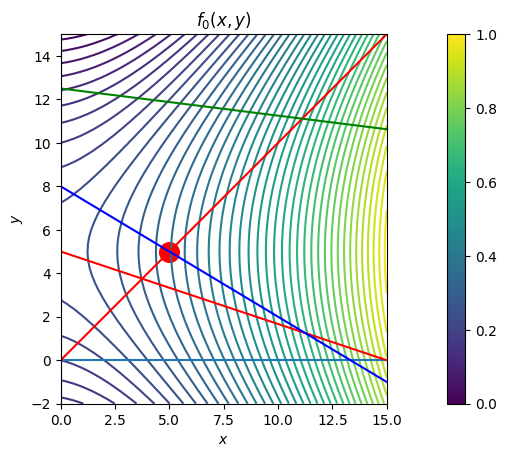

[ 5.00e+00]
[ 5.00e+00]
 6.562500224871206


In [28]:
# Just run the following code, do not modify it

P,q,G,h = make_matrices()
sol, obj = compute_solution_and_objective(P,q,G,h)
plot_solution(sol)
print(sol, obj)

## Kernelized Large Margin Classifiers

In this exercise you are asked to develop the code to solve the optimization problem that defines a kernelized Large Margin Classifier with soft margins. 

### Linear case

We need to match the solver's API which, according to the documentation is of the form:

\begin{aligned}
    & \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ & \ Gx \leq h 
    \\
    & \ Ax = b
\end{aligned}

Recall that the dual problem is expressed as:

\begin{aligned}
\max_{\alpha} \sum_i^m \alpha_i - \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j <x^{(i)}, x^{(j)}>
\end{aligned}

Let $\mathbf{H}$ be a matrix such that $H_{i,j} = y^{(i)}y^{(j)} <x^{(i)} x^{(j)}>$, then the optimization becomes:

\begin{aligned}
    & \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
    \\
     s.t. & \ \alpha_i \geq 0 
    \\
    &  \ \sum_i^m \alpha_i y^{(i)} = 0  
\end{aligned}

We convert the sums into vector form and multiply both the objective and the constraint by −1 which turns this into a minimization problem and reverses the inequality

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
    & s.t. \ - \alpha_i \leq 0 
    \\
    & s.t. \ y^T \alpha = 0 
\end{aligned}

We are now ready to convert our numpy arrays into the cvxopt format, using the same notation as in the documentation this gives

* $P:=H$ a matrix of size $m×m$
* $q:=−\vec{1}$  a vector of size $m×1$
* $G:=−diag[1]$ a diagonal matrix of -1s of size $m×m$
* $h:=\vec{0}$ a vector of zeros of size $m×1$
* $A:=y^T$ the label vector of size $1×m$
* $b:=0$ a scalar

Note that in the simple example of $m=2$ the matrix $G$ and vector $h$ which define the constraint are 

$$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \end{bmatrix} \ \ \text{and} \ \ h = \begin{bmatrix} 0 \\ 0  \end{bmatrix}$$

### Computing the matrix $\mathbf{H}$ in vectorized form

Consider the simple example with 2 input samples $\{x^{(1)}, x^{(2)}\} \in \mathbb{R}^2$ which are two dimensional vectors. i.e. $x^{(1)} = (x_1^{(1)} , x_2^{(1)})^T$

$$X = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} \\ x_1^{(2)} & x_2^{(2)} \end{bmatrix} \ \ \text{and} \ \ y = \begin{bmatrix} y^{(1)}  \\ y^{(2)} \end{bmatrix}$$

We now proceed to creating a new matrix $X′$ where each input sample $x$ is multiplied by the corresponding output label y. This can be done easily in Numpy using vectorization and padding.

$$X' = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix}$$

Finally we take the **matrix multiplication** of $X′$ and its transpose giving $H=X′X′^T$

$$H = X' @ X'^T = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix} \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(2)}_1 y^{(2)}  \\
x^{(1)}_2y^{(1)} & x^{(2)}_2y^{(2)} \end{bmatrix}$$

$$H = \begin{bmatrix}  x^{(1)}_1 x^{(1)}_1y^{(1)}y^{(1)} + x^{(1)}_2x^{(1)}_2y^{(1)}y^{(1)} & x^{(1)}_1 x^{(2)}_1y^{(1)}y^{(2)} + x^{(1)}_2x^{(2)}_2y^{(1)}y^{(2)} \\ x^{(2)}_1 x^{(1)}_1y^{(2)}y^{(1)} + x^{(2)}_2x^{(1)}_2y^{(2)}y^{(1)} & x^{(2)}_1 x^{(2)}_1y^{(2)}y^{(2)} + x^{(2)}_2x^{(2)}_2y^{(2)}y^{(2)} \end{bmatrix}$$


### Soft margin
For the softmax margin SVM, recall that the optimization problem can be expressed as

\begin{aligned}
    & \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
    \\
     s.t. \ \ & 0 \leq \alpha_i \leq C 
    \\
    &  \ \sum_i^m \alpha_i y^{(i)} = 0  
\end{aligned}

which can be written in standard form as

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
     s.t. & \ - \alpha_i \leq 0 
    \\
     & \alpha_i \leq C
     \\
     &\ y^T \alpha = 0  
\end{aligned}

This is almost the same problem as previously, except for the additional inequality constraint on $\alpha$. We translate this new constraint into standard form by concatenating below matrix $G$ a diagonal matrix of 1s of size $m \times m$. Similarly for the vector $h$ to which the value of $C$ is added $m$ times.

Note that in the simple example of $m=2$ the matrix $G$ and vector $h$ which define the constraint are

$$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ 1 & 0 \\ 0 & 1\end{bmatrix} \ \ \text{and} \ \ h = \begin{bmatrix} 0 \\ 0 \\ C \\ C \end{bmatrix}$$

### Non linear case

What has been written above corresponds to the hard and the soft margin case for a linear large margin classification problem.  

You now need to appy the *kernel trick*, i.e. you need to replace the dot product operations in the input space $<x^{(i)} x^{(j)}>$ with the dot product in the feature space via a kernel function $K(x^{(i)},x^{(j)}) = <\phi(x^{(i)}) \phi(x^{(j)})>$. 

## Question 9

**Do not consider this question**

<strike>Make the function `X_prime = make_X_prime(X,t, kernel_function, param)` to compute $X′$ for a data matrix `X` and an associated target vector `t`.</strike>

In [29]:
# This question is no longer valid. Do not consider it.
# No implementation is necessary here.
# Disregard the following: raise NotImplementedError()

    # YOUR CODE HERE
    #raise NotImplementedError()

In [30]:
# This cell is will not perform any unit tests. Do not consider this cell. 

## Question 10

Make the function `H = make_H_k(X,t, kernel_function, param)` to compute the matrix $H$ for a data matrix `X` and an associated target vector `t` given a kernel function `kernel_function` with parameter `param`. 

In [31]:
def make_H_k(X,t, kernel_function, param):
    samples,cols  = np.shape(X)
    k_matrix = np.zeros((samples, samples))
    for r in range(samples):
        for c in range(samples):
            k_matrix[r, c] = kernel_function(X[r],X[c],param)
    return np.outer(t,t) * k_matrix

In [32]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 11

Make the function `P, q, G, h, A, b = setup_optimization_soft_k(X, t, C, kernel_function, param)` to compute the necessary matrices to solve the QP problem associated to the soft margin kernelized classification task using the library [cvxopt](http://cvxopt.org/). The function receives in input a data matrix `X`, an associated target vector `t`, a regularization parameter `C` and a kernel function `kernel_function` with parameter `param`. 

In [33]:
def setup_optimization_soft_k(X,t,C, kernel_function, param):
    m, n = X.shape
    t = t.reshape(-1, 1).astype(float)
    H = make_H_k(X,t,kernel_function,param)
    P = matrix(H, tc='d')
    q = matrix(-np.ones((m, 1)),tc='d')
    if C is None:
        G = matrix(-np.eye(m))
        h = matrix(np.zeros(m))
    else:
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(t.reshape(1, -1),tc='d')
    b = matrix(np.zeros(1),tc='d')
    return P, q, G, h, A, b

In [34]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 12

Make the function `support_vectors, support_targets, support_alphas, support_ids = compute_support_vectors(X,t,alphas)`  to compute:
- `support_vectors` the support vectors
- `support_targets` the target vector associated to the support vectors
- `support_alphas` the vector of the dual variables $\alpha_i$ associated to the support vectors
- `support_ids` a boolean vector that indicates if a position is associated to a support vector (w.r.t. the original data matrix) (i.e. if the first instance is a support vector and the second one it is not, then `support_ids` = [True, False])

In [35]:
def compute_support_vectors(X,t,alphas):
    t = t.reshape(-1, 1).astype(float)
    s_ids = (alphas > 1e-4).flatten()
    s_vectors = X[s_ids]
    s_targets = t[s_ids]
    s_alphas = alphas[s_ids]
    return s_vectors,s_targets,s_alphas, s_ids

In [36]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 13

Make the function `model = train_slmkc(X, t, C, kernel_function, param)` to compute the necessary elements to represent a kernelized soft large margin classifier trained over an input data matrix `X` with an associated target vector `t`, for a regularization parameter `C` and a kernel function `kernel_function` with parameter `param`. 

Note: you may implement `model` as a tuple containing information on the support vectors and the dual variables, i.e. `model = (support_vectors,support_targets,support_alphas, support_ids)`.

In [37]:
def train_slmkc(X, t, C, kernel_function, param):
    P, q, G, h, A, b = setup_optimization_soft_k(X,t,C,kernel_function, param)
    solvers.options['show_progress'] = False
    solvers.options['abstol'] = 1e-10
    solvers.options['reltol'] = 1e-10
    solvers.options['feastol'] = 1e-10
    solution_dict = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution_dict['x'])
    return compute_support_vectors(X,t,alphas)

In [38]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 14

Given the kernelized soft large margin discriminant function of the form:
$$ y(x) = \sum_{n \in SV} \alpha_n t_n K(x_n,x) + b $$

and given the encoded `model` to represent the necessary elements for a trained kernelized soft large margin classifier

make the function `b = compute_bias(kernel_function, param, C, model)` to compute the offset/bias term `b`,  for a regularization parameter `C` and a kernel function `kernel_function` with parameter `param`. 

In [39]:
def applyC(model,C):
    s_vectors,s_targets,s_alphas, s_ids = model
    idx = (s_alphas < C).ravel()
    s_vectors = s_vectors[idx]
    s_targets = s_targets[idx]
    s_alphas = s_alphas[idx]
    return s_vectors,s_targets,s_alphas, idx

def compute_bias(kernel_function, param, C, model):
    s_vectors,s_targets,s_alphas, s_ids = applyC(model,C)
    b = np.sum(s_targets)
    for i in range(len(s_vectors)):
        b -= np.sum((s_alphas[i] * s_targets[i]) * kernel_function(s_vectors,s_vectors[i], param))
    return b/len(s_targets)

In [40]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [41]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 15

Make the function `scores = score_slmkc(X_test, kernel_function, param, C, model)` to compute the scores for the kernelized soft large margin discriminant function over the data matrix `X_test`, for a regularization parameter `C`, a kernel function `kernel_function` with parameter `param` and an encoded model `model`.

In [42]:
def score_slmkc(X_test, kernel_function, param, C, model):
    s_vectors,s_targets,s_alphas, s_ids = applyC(model,C)
    b = compute_bias(kernel_function, param, C, model)
    p = []
    for x in X_test:
        predictions = 0
        for i in range(len(s_vectors)):
            predictions += (s_targets[i] * s_alphas[i]) * kernel_function(x,s_vectors[i],param)
        predictions += b
        p.append(predictions)
    return np.asarray(p)

In [43]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [44]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 16

Make the function `preds = test_slmkc(X_test, kernel_function, param, C, model)` to predict the class label for the kernelized soft large margin discriminant function over the data matrix `X_test`, for a regularization parameter `C`, a kernel function `kernel_function` with parameter `param` and an encoded model `model`.

In [45]:
def test_slmkc(X_test, kernel_function, param, C, model):
    return np.sign(score_slmkc(X_test, kernel_function, param, C, model)).astype(int).flatten()

In [46]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [47]:
# this function is provided to you, you do not need to alter it in any way.

class MySoftLargeMarginKernelClassfier(object):
    def __init__(self, C, kernel_function, param):
        self.kernel_function = kernel_function
        self.param = param
        self.C = C
        self.support_vectors = None
        self.support_targets = None
        self.support_alphas = None
        self.support_ids = None
    
    def fit(self, X_train, y_train):
        self.model = train_slmkc(X_train, y_train, self.C, self.kernel_function, self.param)
        self.support_vectors, self.support_targets,self.support_alphas, self.support_ids = self.model
        return self
    
    def predict(self, X_test):
        return test_slmkc(X_test, self.kernel_function, self.param, self.C, self.model)
        
    def decision_function(self, X_test):
        return score_slmkc(X_test, self.kernel_function, self.param, self.C, self.model)
    
    def predict_proba(self, X_test):
        scores = self.decision_function(X_test)
        probs = 1 / (1 + np.exp(-scores))
        return probs

## Question 17

Make the function `linear_kernel_function(x1,x2,param=None)` corresponding to the linear kernel defined as:
$$ K(x_1,x_2) =  x_1^T x_2 $$
where $x_1$ and $x_2$ are vectors. 

In [48]:
def linear_kernel_function(x1,x2,param=None):
    return np.inner(x1,x2)

In [49]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 18

Make the function `polynomial_kernel_function(x1,x2,param)` corresponding to the polynomial kernel defined by the parameter $r=$`param`:
$$ K(x_1,x_2) =  (1 + x_1^T x_2)^r$$
where $x_1$ and $x_2$ are vectors. 

In [50]:
def polynomial_kernel_function(x1,x2,param):
    return (1 + np.inner(x1,x2)) ** param

In [51]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [52]:
# this function is provided to you, you do not need to alter it in any way.

def plot(X, y, support_vectors=None, predict_func=None):
    cmap='bwr'
    res = 100
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    delta = max((x_max-x_min)/5, (y_max-y_min)/5)
    x_min -= delta
    y_min -= delta
    x_max += delta
    y_max += delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, res),np.linspace(y_min, y_max, res))
    if predict_func is None:
        Z = np.ones(xx.shape)*.5
    else:
        Z = predict_func(np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)]))
        if Z.ndim == 1:
            Z = Z.reshape(xx.shape)
        else:
            Z = Z[:,-1].reshape(xx.shape)
    if support_vectors is None:
        edge_colors = 'w'
        sizes = 50
    else:
        edge_colors = ['k' if s else 'w' for s in support_vectors]
        sizes = [100 if s else 50 for s in support_vectors]
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, levels=20, cmap=cmap, alpha=.5)
    plt.scatter(X[:,0],X[:,1], c=y, s=sizes, edgecolors=edge_colors, cmap=cmap)
    plt.grid()
    plt.axis('equal')
    plt.show()

## Checkpoint

This is just a check-point, i.e. it is for you to see that you are correctly implementing all functions. 

Execute the following code (just execute the next cell):

```python
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.0, class_sep=1.0, random_state=5)
y[y==0]=-1

est = MySoftLargeMarginKernelClassfier(C=1e2, kernel_function=linear_kernel_function, param=None).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict_proba)

est = MySoftLargeMarginKernelClassfier(C=1e-2, kernel_function=polynomial_kernel_function, param=5).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict_proba)
```

You should obtain something like:

<img src='plot3.png' width=300>

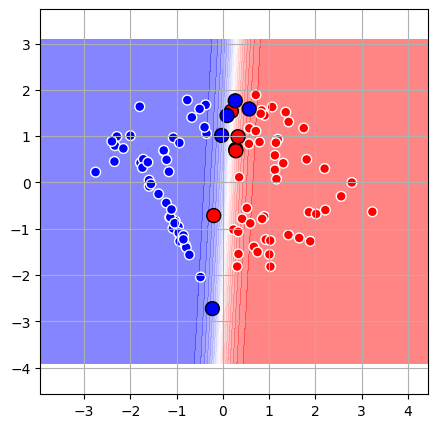

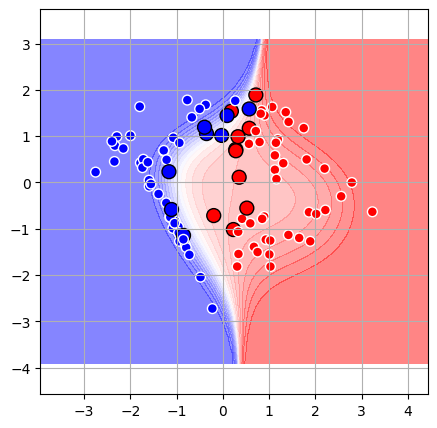

In [53]:
# Just run the following code, do not modify it

from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.0, class_sep=1.0, random_state=5)
y[y==0]=-1

est = MySoftLargeMarginKernelClassfier(C=1e2, kernel_function=linear_kernel_function, param=None).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict_proba)

est = MySoftLargeMarginKernelClassfier(C=1e-2, kernel_function=polynomial_kernel_function, param=5).fit(X, y)
plot(X,y, support_vectors=est.support_ids, predict_func=est.predict_proba)

## Question 19


a) Make a function `estimator = train_svm(X_train, y_train, param)` that takes in input a data matrix `X_train`, an associated target array `y_train`, and a single scalar parameter `param` which corresponds to the regularization parameter of the linear Support Vector machine classifier, and returns a fit classifier object of type `sklearn.svm.LinearSVC`.

b) Make a function `preds = test_svm(X_test, classifier)` that takes in input a data matrix `X_test`, a classifier object `classifier` and returns the prediction array `preds`.

c) Make a function `scores = score_svm(X_test, classifier)` that takes in input a data matrix `X_test`, a classifier object `classifier` and returns the array `scores` containing the distance from the decision surface  for each instance.

In [54]:
from sklearn.svm import LinearSVC

def train_svm(X_train, y_train, param):
    return LinearSVC(C=param).fit(X_train,y_train)

In [55]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [56]:
def test_svm(X_test, estimator):
    return estimator.predict(X_test)

In [57]:
# This cell is reserved for the unit tests. Do not consider this cell. 

In [58]:
def score_svm(X_test, estimator):
    return estimator.decision_function(X_test)

In [59]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 20


The one-vs-one strategy constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. 

In the event of a tie (among all those cases that achieve an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.

Make the function `estimators = train_OvO(X_train, y_train, train_func, param)` that takes in input the data matrix `X_train`, the target vector `y_train`, the training procedure `train_func` with an associated parameter `param` and it outputs an object that represent the estimators fit using the OvO strategy.

In [60]:
def train_OvO(X_train, y_train, train_func, param):
    classes = sorted(set(y_train))
    estimators = dict()
    for i,ci in enumerate(classes):
        for j,cj in enumerate(classes):
            if j>i:
                X = X_train.copy()
                X = X[np.logical_or(y_train==ci,y_train==cj)]
                y = y_train.copy()
                y = y[np.logical_or(y_train==ci,y_train==cj)]
                yp = y.copy()
                yp[y==ci] = 1
                yp[y==cj] = -1
                est = train_func(X, yp, param)
                estimators[(i,j)] = est
    estimators['classes'] = len(classes)
    return estimators

In [61]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 21

Make the function `preds = test_OvO(X_test, test_func, score_func, estimators)` that takes in input the data matrix `X_test`, the classification procedure `test_func`, the score function `score_func`, the estimators object and it returns the predicted class for each instance in the data matrix using the OvO strategy.

Note: only when two or more classifiers end up in a tie the algorithm should resort to the score to break the tie. 

In [62]:
def test_OvO(X_test, test_func, score_func, estimators):
    classes = estimators.pop('classes', len(estimators))
    all_scores = np.zeros((X_test.shape[0], classes))
    all_confidence = np.zeros((X_test.shape[0], classes))
    for i,j in estimators:
        est = estimators[(i,j)]
        preds = test_func(X_test, est)
        score = score_func(X_test, est)
        all_scores[:,i][preds==1]+=1
        all_scores[:,j][preds==-1]+=1
        all_confidence[:,i][preds==1]+=score[preds==1]
        all_confidence[:,j][preds==-1]-=score[preds==-1]
    estimators['classes']=classes
    return np.argmax(all_scores+(all_confidence /(3 * (np.abs(all_confidence) + 1))), axis=1)


In [63]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 22

Make the function `confusion_table(targets, preds)` to output the confusion matrix as a `n x n` Numpy array where `n` is the number of classes. The confusion table is a matrix whose i-th row and j-th column entry indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

As an example, when executing the following code:

```python
test_targets = np.array([0,1,2,0,1,2])
test_preds  =  np.array([0,1,2,0,0,0])
print(confusion_table(test_targets, test_preds))
```
you should obtain:
```
array([[2, 0, 0],
       [1, 1, 0],
       [1, 0, 1]])
```

In [64]:
def confusion_table(targets, preds):
    classes = np.unique(np.union1d(targets,preds))
    confusion_matrix = np.zeros((len(classes),len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
            confusion_matrix[i,j] = np.sum((preds == classes[j]) & (targets == classes[i]))
    return confusion_matrix.astype(int)

In [65]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Cross correlations

In the following section you are asked to work on the notion of cross correlations in 2 and 3 dimensions.

Since the computation of a cross correlation becomes undefined at those positions that are very close to the image boundaries, you are asked to **pad** the original signal, i.e. to extend the signal using a specific strategy.

Note that the resulting cross correlation has the same size as the original signal. 

## Question 23

Make the function `Mp = padding_repeating(M, length)` that takes in input a 2D numpy array `M` and a scalar `length` and pads `M` with `length` replicas of the boundary cells. 

For example running the following code 
```python
n=5
M=np.arange(n*n).reshape(n,n)
print(M)
length=1
print(length)
print(padding_repeating(M, length))
length=2
print(length)
print(padding_repeating(M, length))
```

yields

```
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
1
[[ 0  0  1  2  3  4  4]
 [ 0  0  1  2  3  4  4]
 [ 5  5  6  7  8  9  9]
 [10 10 11 12 13 14 14]
 [15 15 16 17 18 19 19]
 [20 20 21 22 23 24 24]
 [20 20 21 22 23 24 24]]
2
[[ 0  0  0  1  2  3  4  4  4]
 [ 0  0  0  1  2  3  4  4  4]
 [ 0  0  0  1  2  3  4  4  4]
 [ 5  5  5  6  7  8  9  9  9]
 [10 10 10 11 12 13 14 14 14]
 [15 15 15 16 17 18 19 19 19]
 [20 20 20 21 22 23 24 24 24]
 [20 20 20 21 22 23 24 24 24]
 [20 20 20 21 22 23 24 24 24]]
```

In [66]:
def padding_repeating(M, length):
    shape = [M.shape[i] + 2*length for i in range(M.ndim)]
    result  = np.zeros(shape)
    # center
    result[length:M.shape[0]+length,length:M.shape[1]+length] = M
    # top left & right
    result[:length,:length] = M[0,0]
    result[:length,-length:] = M[0,-1]
    # bottom right & left
    result[result.shape[0]-length:,result.shape[1]-length:] = M[-1,-1]
    result[result.shape[0]-length:,:length] = M[-1,0]
    #top and bottom
    result[:length,length:result.shape[1]-length] = M[0,:]
    result[-length:,length:result.shape[1]-length] = M[-1,:]
    # left and right
    for i in range(length):
        result[length:result.shape[0]-length,i] = M[:,0]
        result[length:result.shape[0]-length,result.shape[1]-i-1] = M[:,-1]
    return result.astype(int)

In [67]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 24

Make the function `cross_correlation2D(image, kernel, padding_func)` that takes in input a $m \times n$ 2D array `image` and a square $k \times k$ 2D array `kernel` with $k$ an odd number (e.g. kernel is a 3x3 or 5x5, etc, matrix), and a padding function `padding_func`. The function outputs an array of the same size $m \times n$ as `image` which corresponds to the 2D cross correlation between the padded `image` and `kernel`.

In [68]:
def cross_correlation2D(image, kernel, padding_func):
    kr,kc = kernel.shape
    l=(kr-1)//2
    out = padding_func(image,l)
    r,c = image.shape
    for i in range(r):
        for j in range(c):
            image[i,j] = np.sum(out[i:i+kr,j:j+kc]*kernel)
    return image

In [69]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 25

Make the function `padding_zeros_3D(M, length)` that takes in input a 3D numpy array `M` and a scalar `length` and pads `M` with with replicas of 0 entries along all sides.

For example:
```python
padding_zeros_3D(np.ones((3,3,3)), length=1)
```
yields
```
array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])
```

In [70]:
def padding_zeros_3D(M, length):
    shape = [M.shape[i]+2*length for i in range(M.ndim)]
    result  = np.zeros(shape)
    result[length:M.shape[0]+length,length:M.shape[1]+length,length:M.shape[2]+length] = M
    return result

In [71]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 26

Make the function `cross_correlation3D(image, kernel, padding_func)` that takes in input a $m \times n \times p$ 3D array `image` and a square $k \times k \times k$ 3D array `kernel` with $k$ an odd number (e.g. kernel is a 3x3x3 or 5x5x5, etc, matrix), and a padding function `padding_func`. The function outputs an array of the same size $m \times n \times p$ as `image` which corresponds to the 3D cross correlation between the padded `image` and `kernel`.

In [72]:
def cross_correlation3D(image, kernel, padding_func):
    kr,kc,kh = kernel.shape
    l=(kr-1)//2
    out = padding_func(image,l)
    r,c,h = image.shape
    for i in range(r):
        for j in range(c):
            for k in range(h):
                image[i,j,k] = np.sum(out[i:i+kr,j:j+kc,k:k+kh]*kernel)
    return image

In [73]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Question 27 

Make the function `make_averaging_kernel(n_dim, length)` that generates a kernel with `n_dim` dimensions (e.g. n_dim = 3) of shape $(l \times l \times \ldots l)$ with $l=$`lenght`. The function should build a specific kernel that, when used in a cross correlation operation, computes the average of all the values in its field of action (e.g. a 3x3x3 kernel makes the average of the 27 neighboring cells).

In [74]:
def make_averaging_kernel(n_dim, length):
    return np.ones([length for _ in range(n_dim)])/(length ** n_dim)

In [75]:
# This cell is reserved for the unit tests. Do not consider this cell. 

## Checkpoint

This is just a check-point, i.e. it is for you to see that you are correctly implementing all functions. 

Note that a color image is encoded as a 3D array, where the 3rd dimension is used to encode the color information.

Execute the following code (just execute the next cell):

```python
from PIL import Image
image = np.array(Image.open('fish.jpeg')).astype(int)

# original image
print(image.shape)
plt.imshow(image)
plt.show()

# correlation
kernel = make_averaging_kernel(n_dim=3, length=7)
out = cross_correlation3D(image, kernel, padding_zeros_3D)
out = out.astype(int)
plt.imshow(out)
plt.show()
```

You should obtain something like:
```
(510, 510, 3)
```

<img src='plot4.png' width=300>

(510, 510, 3)


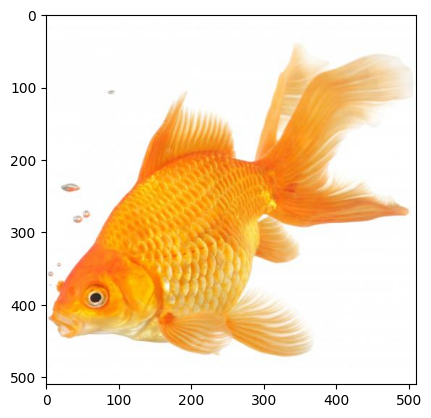

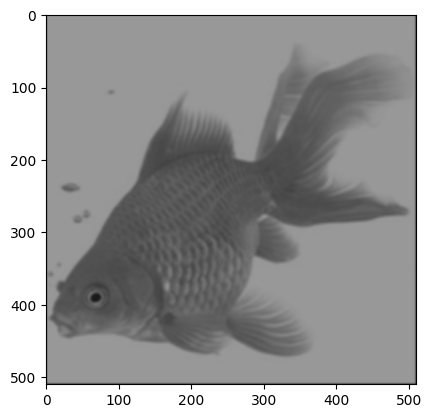

In [76]:
# Just run the following code, do not modify it

from PIL import Image
image = np.array(Image.open('fish.jpeg')).astype(int)

# original image
print(image.shape)
plt.imshow(image)
plt.show()

# correlation
kernel = make_averaging_kernel(n_dim=3, length=5)
out = cross_correlation3D(image, kernel, padding_zeros_3D)
out = out.astype(int)
plt.imshow(out)
plt.show()

